<center/>

# **CefPro Risk Americas 2023 ML Model Validation Masterclass**

## Fair Machine Learning: 
## Testing Models for Discrimination and Bias

#### May 22, 2023
</center>

## Introduction

This notebook provides an introduction to measuring discrimination in the outcomes of machine learning models.  In this notebook, we do the following:

1. Use PiML to build and evaluate a model based on synthetic consumer credit data.

2. Demonstrate some of the exploratory data analysis capabilities of PiML.

3. Use some of the model explanation tools in PiML to gain insight into how the model is using various features.

4. Use PiML's implementation of the SolasAI disparity testing library to evaluate whether there is evidence that the model built shows discrimination.

5. Use the SolasAI API to test other metrics of disparaties.

## Importing the Libraries Used in the Analysis

Below, we install the SolasAI and PiML libraries.  

**_If you are running this in Google Colab: after running this line, you will need to restart your runtime before running subsequent code._**

In [58]:
# !pip install solas-ai PiML jinja2 -U

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [2]:
import solas_disparity as sd
from piml import Experiment

import pandas as pd

### Data Preparation

The following code imports a simulated credit dataset developed by the creators of PiML.  We make several minor modifications to the PiML version that will help us in teaching how to use some features of PiML and the SolasAI library.  This dataset includes whether a loan was `approved` or not.  Below, in order to conform with typical practice, we change this to indicate whether the loan defaulted.  There are seven features available for modeling whether the loan defaulted: `mortgage balance`, `account balances`, `amounts past due`, `delinquency status`, `number of credit inquiries`, `number of open trades`, and `percent utilization`.

The dataset also includes information about each synthetic borrower's race or ethnicity (`Black`, `Hispanic`, and `White`), gender (`Female` and `Male`), and age (`Age >= 62` and `Age < 62`).  Race and ethnicity are based on proportional estimates, while gender and age are binary values.

After importing the data, we perform several minor data manipulation steps.

In [3]:
df = pd.read_parquet("https://github.com/SolasAI/solas-ai-disparity/blob/main/examples/data/20221221_simulated_credit_data_w_preds.parquet.gz?raw=true")
df['Default'] = 1 - df['Approved']
df = (df
      .drop(columns=['Approved', 'Baseline Prediction', 'Baseline Offer', 'Minority', 'Majority'])
      .rename(columns={'Minority-1-Proportional': 'Black', 'Minority-2-Proportional': 'Hispanic', 'Majority-Proportional': 'White'})
      .sort_index(level=['Train', 'ID'])
      .reset_index(drop=False)
)
df.sample(random_state=161803, n=5)

,Train,ID,Sample Weight,Mortgage,Balance,Amount Past Due,Delinquency Status,Credit Inquiry,Open Trade,Utilization,Gender,Race,Age,Female,Male,Age >= 62,Age < 62,Black,Hispanic,White,Default
83419,valid,17149,5.763312,343699.96,3843.43,3491.35,1.0,1.0,1.0,0.743297,Male,Majority,Age >= 62,0.0,1.0,1.0,0.0,0.011932,0.007068,0.981,1
25011,train,21419,12.409537,170872.69,931.11,0.00,0.0,1.0,1.0,0.183434,Male,Minority,Age >= 62,0.0,1.0,1.0,0.0,0.528570,0.310430,0.161,0
79016,train,98564,7.360731,163041.61,895.05,0.00,0.0,0.0,0.0,0.567924,Male,Minority,Age >= 62,0.0,1.0,1.0,0.0,0.393291,0.407709,0.199,0
22197,train,17432,13.661012,136040.57,80.75,52.02,2.0,0.0,0.0,0.219620,Female,Minority,Age >= 62,1.0,0.0,1.0,0.0,0.599090,0.262910,0.138,1
48321,train,54792,16.327007,247120.04,531.62,0.00,0.0,0.0,0.0,0.278665,Female,Majority,Age >= 62,1.0,0.0,1.0,0.0,0.073884,0.057116,0.869,0


Below, we identify the observations that PiML will use for training and those for validation.  With PiML, a user can send in index values for the training and test set, or they can split the data using `sklearn.train_test_split()` (this happens automatically in PiML). 

In [4]:
train_valid = df.loc[df['Train'].isin(['train', 'valid']), :]
train_valid = train_valid.reset_index(drop=True)
idx_train = train_valid.loc[train_valid['Train'] == 'train'].index.values
idx_valid = train_valid.loc[train_valid['Train'] == 'valid'].index.values

## Running PiML

### Preparing the PiML `Experiment()`

Below, we instantiate a PiML Experiment. This object will have all the PiML functionality we will use for the various analyses.  We then import the data and prepare it for model building and analysis.

In [5]:
exp = Experiment()

In [6]:
exp.data_loader(train_valid)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

,Train,ID,Sample Weight,Mortgage,Balance,Amount Past Due,Delinquency Status,Credit Inquiry,Open Trade,Utilization,Gender,Race,Age,Female,Male,Age >= 62,Age < 62,Black,Hispanic,White,Default
0,train,0.0,2.808925,437370.03,455.59,0.0,0.0,0.0,0.0,0.812178,Female,Majority,Age < 62,1.0,0.0,0.0,1.0,0.075012,0.018988,0.906,1.0
1,train,2.0,4.113696,167561.64,3207.68,759.8,5.0,0.0,0.0,0.83197,Male,Minority,Age >= 62,0.0,1.0,1.0,0.0,0.694152,0.238848,0.067,1.0
2,train,4.0,8.228959,149960.24,113.84,0.0,0.0,1.0,1.0,0.104844,Female,Minority,Age >= 62,1.0,0.0,1.0,0.0,0.389825,0.385175,0.225,1.0
3,train,7.0,17.296648,294669.99,1012.39,584.67,5.0,3.0,0.0,0.2696,Male,Majority,Age < 62,0.0,1.0,0.0,1.0,0.182358,0.114642,0.703,0.0
4,train,11.0,5.329857,358261.24,1369.99,175.03,1.0,0.0,0.0,0.95705,Female,Majority,Missing,1.0,0.0,NaN,NaN,0.046398,0.064602,0.889,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,valid,99960.0,7.600522,233889.3,1542.14,0.0,0.0,0.0,0.0,0.812273,Female,Majority,Age < 62,1.0,0.0,0.0,1.0,0.094044,0.109956,0.796,1.0
89996,valid,99975.0,8.161375,183012.62,541.83,0.0,0.0,0.0,0.0,0.41627,Female,Majority,Age < 62,1.0,0.0,0.0,1.0,0.114345,0.050655,0.835,0.0
89997,valid,99977.0,17.593494,374188.42,1234.95,0.0,0.0,0.0,0.0,0.595542,Male,Majority,Age < 62,0.0,1.0,0.0,1.0,0.1599,0.0451,0.795,1.0
89998,valid,99985.0,4.624287,141112.05,684.5,284.96,1.0,1.0,0.0,0.17127,Male,Minority,Age >= 62,0.0,1.0,1.0,0.0,0.59706,0.33294,0.07,0.0


### Summary Statistics

We can easily obtain summary statistics for our features and label.

In [7]:
exp.data_summary(
    feature_exclude=[x for x in df if x not in ['Mortgage', 'Balance', 'Amount Past Due', 'Delinquency Status', 'Credit Inquiry', 'Open Trade', 'Utilization', 'Default']]
)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value='Data Shape:(90000, 21)')

### Exploratory Data Analysis

Now that we have loaded the data into the PiML experiment, we can perform an Exploratory Data Analysis (EDA).  In the code below, we create a univariate analysis of the `Mortgage Balance` variable, bi-variate analysis of `Amount Past Due` and `Utilization`, and create a correlation heatmap of all of the features.

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

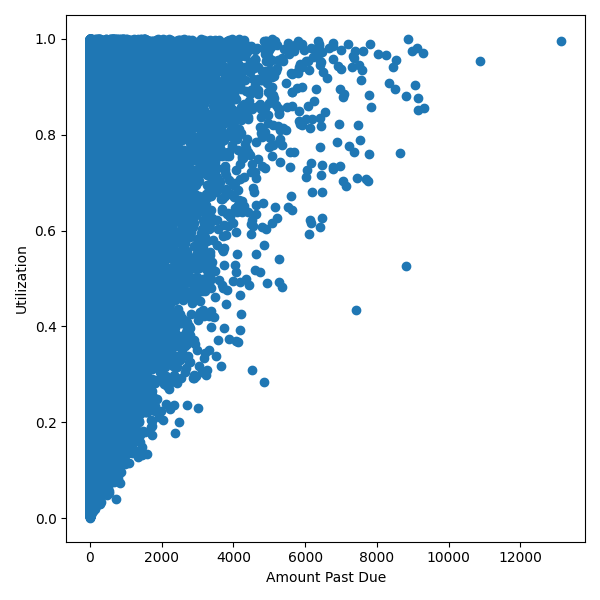

In [8]:
exp.eda(
    show='bivariate', 
    bi_features=['Amount Past Due', 'Utilization'],  
    multi_type='correlation_heatmap'
)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

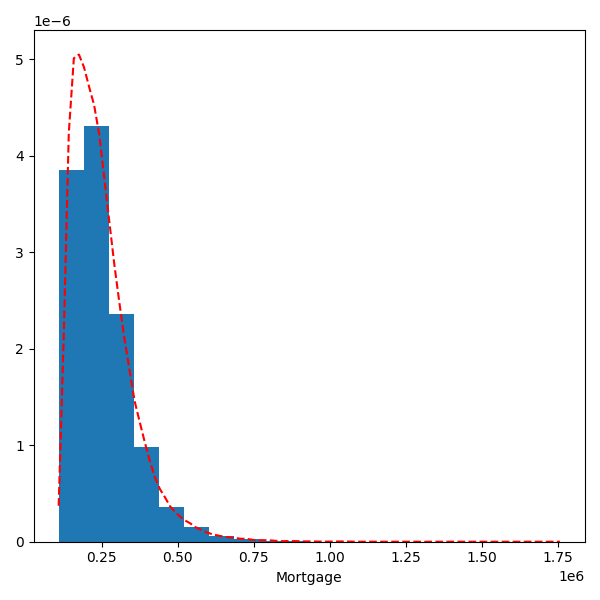

In [9]:
exp.eda(
    show='univariate', 
    uni_feature='Mortgage', 
)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

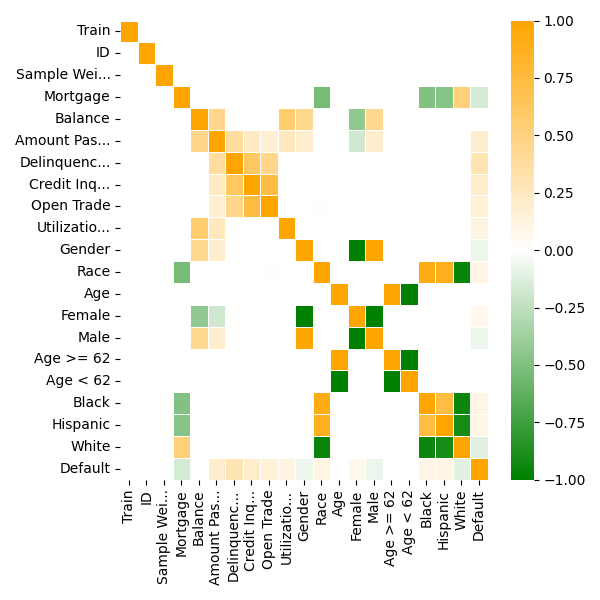

In [10]:
exp.eda(
    show='multivariate', 
    multi_type='correlation_heatmap'
)

For the **univariate analysis** of Mortgage we see a strong right skew, which is what we would expect.

The **bivariate analysis** of Amount Past Due and Utilization shows an interesting relationship in which higher Amount Past Due values correspond with higher Utilization values, but the reverse is not true.

One interesting observation in the multivariate analysis is that the only negative correlation is between Mortgage and Default. Although this may be counterintuitive at first, it makes sense since those with a mortgage have likely been deemed creditworthy during a rigorous underwriting process.

### Building Models with PiML

PiML has a number of interpretable models, inclduing Wells Fargo's GAMI-Net and Microsoft's Explainable Boosting Machine ("EBM").  Using the code below, we build a relatively simple EBM and then print the accuracy results.  Given prior knowledge of the data, we can say that this model's metrics look quite solid.  Further, the minimal "Gap" indicates there is little risk that the model has overfit to the training data.

### Data and Model Preparation

We prepare the data and model for training by setting the label, the learning task, the training and test datasets, and sample weights.

In [11]:
exp.data_prepare(
    target='Default', 
    task_type='Classification', 
    train_idx=idx_train,
    test_idx=idx_valid,
    random_state=161803, 
    sample_weight='Sample Weight',
  )

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

,Config,Value
0,Excluded columns,"[White, Age, Black, Female, Gender, Age < 62, Hispanic, ID, Train, Male, Race, Age >= 62]"
1,Target variable,Default
2,Sample weight,Sample Weight
3,Task type,Classification
4,Split method,Manual
5,Test ratio,0.222222
6,Random state,161803
7,Train test energy distance,0.000044


### Model Training

We now choose a model aritecture, set hyperparameters, and train the model.

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

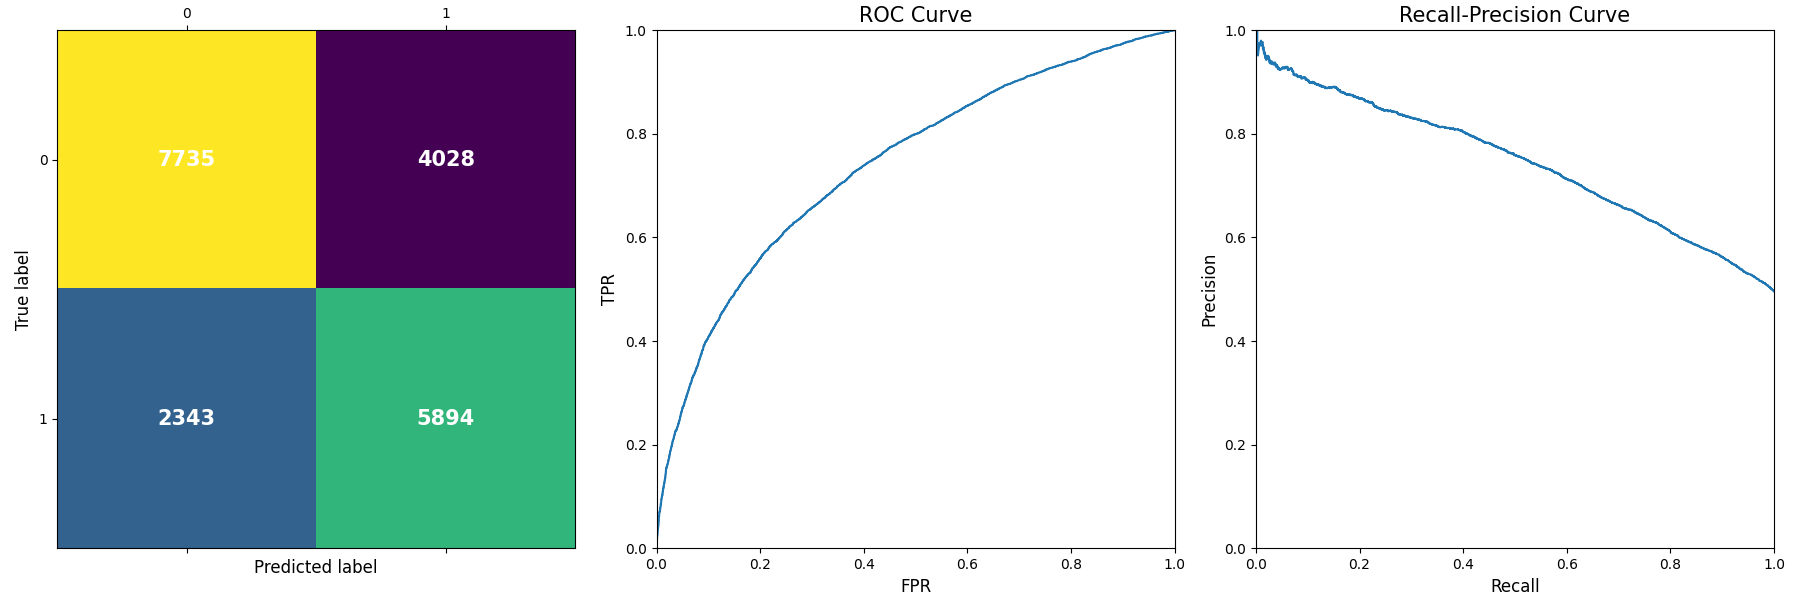

None

In [12]:
from piml.models import ExplainableBoostingClassifier
from piml.models import XGB2Classifier

ebm = ExplainableBoostingClassifier(interactions=3, random_state=0)
exp.model_train(model=ebm, name='EBM')
display(exp.model_diagnose(model="EBM", show='accuracy_plot'))

In [13]:
xgb = XGB2Classifier()
exp.model_train(model=xgb, name='XGB')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [14]:
print(f"Depth-2 XGBoost Accuracy Metrics:")
display(exp.model_diagnose(model="XGB", show='accuracy_table'))
print(f"EBM Accuracy Metrics:")
display(exp.model_diagnose(model="EBM", show='accuracy_table'))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

Depth-2 XGBoost Accuracy Metrics:


,ACC,AUC,Recall,Precision,F1
,,,,,
Train,0.6882,0.7512,0.6133,0.7112,0.6586
Test,0.6797,0.7398,0.6079,0.7075,0.6539
Gap,-0.0084,-0.0114,-0.0054,-0.0038,-0.0047


None

EBM Accuracy Metrics:


,ACC,AUC,Recall,Precision,F1
,,,,,
Train,0.6842,0.7467,0.5932,0.7146,0.6482
Test,0.6792,0.7388,0.5928,0.7142,0.6478
Gap,-0.0050,-0.0080,-0.0004,-0.0004,-0.0004


None

## Model Explanations

PiML contains a number of model explanation tools. Here, we focus on Shapley values: a powerful and widely used explanatory tool. Shapley values assign a value to each feature for each observation and these values sum to the observation's model prediction. This provides two powerful insights:


*   an explanation of how the algorithm reached each prediction 
*   a measure of feature importance




We start by examining the Shapley values for a single observation. Shapley values begin with the same expected value for all observations (0.526) and then each feature moves the prediction up or down (indicated by the red and blue arrows). Features at the bottom have the least impact and features at the top have the most impact. Here, the model prediction for this observation is 0.31 after summing the expected value and all the Shapley values.

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

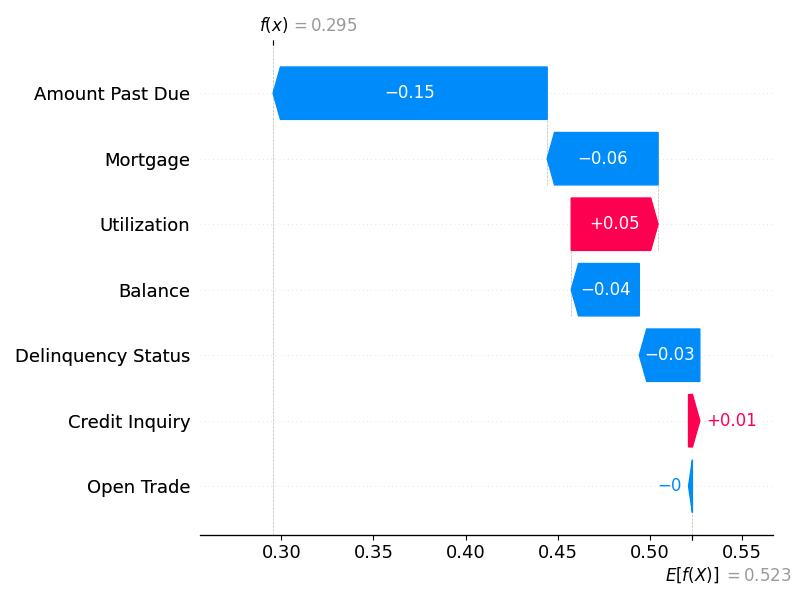

In [15]:
exp.model_explain(model='XGB', show='shap_waterfall', sample_id=1000)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

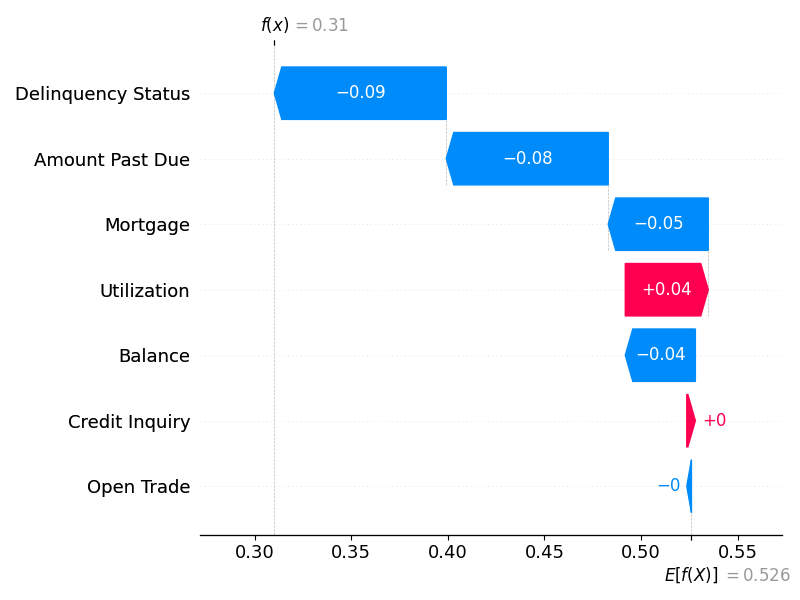

In [16]:
exp.model_explain(model='EBM', show='shap_waterfall', sample_id=1000)

In addition to providing an explanation into how the prediction for a single observation was reached, Shapley values can reveal overall trends in how features are used in the model. A sample of 400 observations is drawn and the underlying feature values and corresponding Shapley values are plotted.

A number of trends are observed.

*   **Utilization:** There is a clear relationship – higher feature values yield higher Shapley values. This makes sense since a higher utilization would likely increase the risk of default. In addition, the range of Shapley values is large compared to the other features. This tells us that Utilization is an important feature – it can increase or decrease predictions by a significant amount. 

*   **Open Trade:** This feature demonstrates the same relationship as Utilization, but the range of Shapley values is much smaller. This indicates that the feature is less important and does not significant change predictions.

*   **Mortgage:** This feature shows the opposite relationship – lower Mortgage balances indicate a higher risk of default. This corresponds with our observation during the exploratory analysis and the negative correlation between Mortgage and Default.

*   **Amount Past Due:** This feature reveals a more interesting relationship. Most low feature values have negative Shapley values and therefore decrease the default prediction, which makes sense intuitively. However, there are a significant number of low feature value observations that are interspersed with medium and high feature values and are actually increasing the prediction of default. It is not obvious why this would be and may warrant further analysis.


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

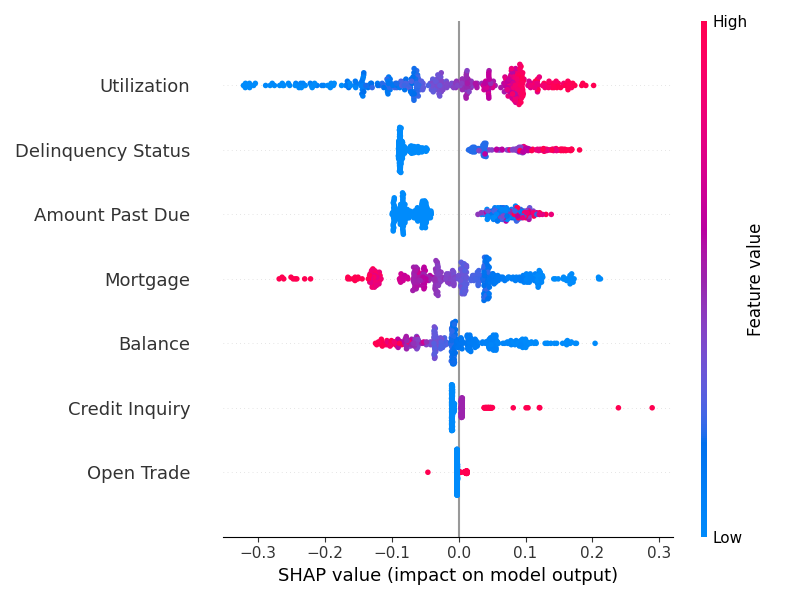

In [17]:
exp.model_explain(model='EBM', show='shap_summary', sample_size=400)

## Background on Model Fairness

Now that we have a model that has been built, we can test it for fairness.  However, before jumping into the fairness testing code, we provide a short explanation of several terms used in model fairness analyses.


### "Protected" and "Reference" Groups

In fairness analyses, we typically test whether some group(s) achieve outcomes that are _at least as good_ as another group's outcomes. The first group(s) are identified as `protected_groups`.  These typically include groups of people who have been or are continuing to experience some form of discrimination or disadvantage.  In the United States, this would often include minority races, women, older people, and others (depending on the law and context).

The outcomes for members of these groups are then compared to those of the `reference_groups`, which are members of groups that typically have not been subject to the same type or degree of discrimination or disadvantage.  In the United States, this would usually include non-Hispanic Whites, men, or younger people.

When using some of the functionality below, a user needs to specify values for a third attribute, `group_categories`. This is used to delineate between different protected-reference group combinations. For example, `group_categories` might be race, sex, age, medical diagnoses, etc. By way of example, classifications most commonly used by SolasAI's U.S. customers are:

<center/>

| `group_categories` | `protected_group` | `reference_group` |
|--------------------|-------------------|-------------------|
| Race / Ethnicity   | Black             | White             |
| Race / Ethnicity   | Hispanic          | White             |
| Race / Ethnicity   | Asian             | White             |
| Sex                | Female            | Male              |
| Age                | Age >= X          | Age < X           |

</center>

For the synthetic data that we are analyzing, we will perform analyses for `Race/Ethnicity` (`Black`/`Hispanic` versus `non-Hispanic White`), Sex (`Female` versus `Male`), and Age (`62+` versus `under 62`).  To do this, we create the lists below for the three attributes:

In [18]:
protected_groups = ["Black",          "Hispanic",       "Female", "Age >= 62"]
reference_groups = ["White",          "White",          "Male",   "Age < 62"]
group_categories = ["Race/Ethnicity", "Race/Ethnicity", "Sex",     "Age"]

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

### Outcomes, Labels, and Segments

SolasAI can be used to measure disparities created as the result of automated systems, semi-automated systems, or entirely subjective processes.  

Regardless of the use case, when the user calculates disparity, they will need to specify the `outcome` attribute.  In some cases, this will be a binary (i.e., "Yes" or "No") outcome, such as whether a person was offered a job, loan, or sent a marketing offer.  In other cases, it may be a continuous value, such as a model's probability of loan default, the amount of time it takes for a person to be promoted, or an employee's pay rate.  Of the metrics SolasAI provides, some are appropriate for the binary case (e.g., `adverse_impact_ratio`), while others are appropriate for analyses of continuous values (e.g., `standardized_mean_difference`).

When measuring disparities that arise from the use of a model, and when the true outcome is known, a user can specify the `label` attribute.  Certain metrics, such as the `residual_standardized_mean_difference`, require the label to be present because the disparity measurement incorporates the label.

Some metrics, including the `segmented_adverse_impact_ratio` perform analyses on subsets of the data and then aggregate the results.  SolasAI refers to these subsets using the `segment` attribute.  Examples of segments might be different store locations, job openings, or job types.  Care should be used when deciding whether to incorporate segmentation into an analysis.

### Statistical Significance and Practical Significance

It is typical to use thresholds of statistical significance and "practical" significance to determine whether any potential disparities found are sufficiently large to warrant further review or action.  What may constitute appropriate and reasonable standards is likely driven by regulatory and legal requirements, business decisions, or other factors.

Importantly, for SolasAI to identify that a result is "practically significant," it must _both_ be found to be statistically significant and exceed the practical significance thresholds set. 

## Model Fairness Using PiML



PiML contains a suite of tools for measuring fairness using various metrics and for testing various techniques (thresholding, binning, and feature removal) for mitigating unfairness.

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

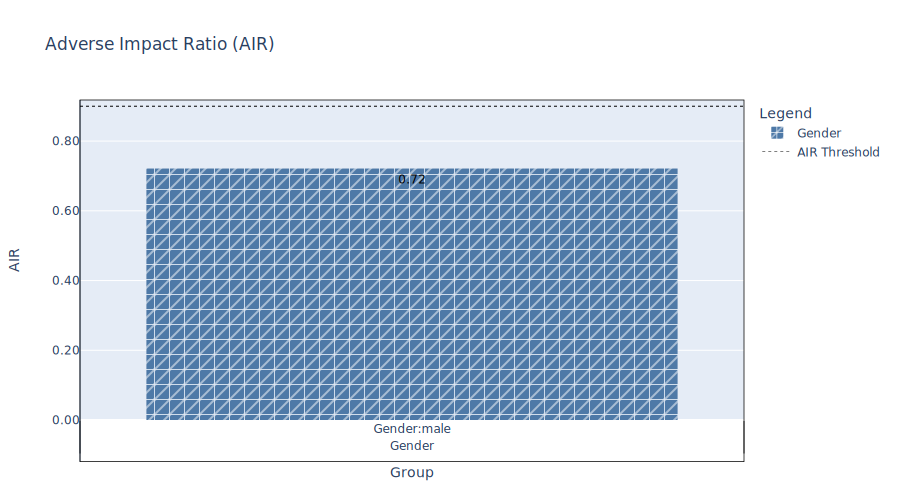

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant
Gender,Gender:Male,Gender:Female,"90,000",0.00%,"44,820.0","6,307.0",14.07%,5.44%,0.721,0.000,Yes
Gender,Gender:Female,,"90,000",0.00%,"45,180.0","8,814.0",19.51%,,,,


In [57]:
exp.model_fairness_solas(
    model='EBM',
    metric='AIR',
    protected_group=['Male'],
    reference_group=['Female'],
    group_category=['Gender'],
    favorable_threshold=0.75,
    metric_threshold=0.9,
    show='metrics',
)

In addition, PiML can test for model fairness using SolasAI's disparity testing package. The metrics in this package have widespread usage in highly regulated industries such as credit and employment and are generally accepted by courts and regulators.

In [26]:
exp.model_fairness_solas()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Fairness Using SolasAI

SolasAI's disparity testing package is also freely available separate from the PiML package. The package uses a programatic testing approach that allows for automated model testing. In addition, it provides a user with more fine-grained control of the testing process (whether a higher or lower score is more favorable, for example) and richer reporting (the statistical significance of any disparity that is found, for example). The SolasAI package also allows for analysis using proportional estimation – that is, the use of probabilities for class membership. This is generally regarded as the best practice for handling race/ethnicity classifications.

Below, we use the native SolasAI API to test for discrimination.  We perform two types of tests: the Adverse Impact Ratio (AIR) test, and the Standardized Mean Difference (SMD) test.  The AIR is used for binary (yes/no) outcomes, but the SMD is typically used for continuous measures like a model's raw score.  

Therefore, before we can calculate the AIR, we have to determine the binary "Offer" / "No Offer" outcome.  We do this by assuming that anyone with a model probability less than 0.25 (i.e., they have less than a 25% chance of default) gets an offer for a loan.

In [47]:
train = df.loc[df['Train'] == 'train', :].copy()
train['Model Probability'] = exp.get_model("EBM").predict_proba(exp.get_raw_data().train_x)[:, 1]
train['Offer'] = (train['Model Probability'] < 0.25).astype(int)
train['Offer'].value_counts(dropna=False, normalize=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

0    0.896357
1    0.103643
Name: Offer, dtype: float64

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

## Disparity Calculation: Adverse Impact Ratio

┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                      │ Black, Hispanic, Female, Age >= 62                                      │
│ Reference Groups                      │ White, White, Male, Age < 62                                            │
│ Group Categories                      │ Race/Ethnicity, Race/Ethnicity, Sex, Age                                │
│ AIR Threshold                         │ 0.8                                                                     │
│ % Diff Threshold                      │ 0.0                                                                     │
│ Affected Groups                       │ Black, Hispanic, Female                                                 │
│ Affected Reference                    │ White, White, Male                                                      │
│ Affected Categories                   │ Race/Ethnicity, Race/Ethnicity, Sex                                     │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

\* Percent Missing: Age: 4.96%, Race/ethnicity: 9.97%, Sex: 0.00%

## Adverse Impact Ratio Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant
Race/Ethnicity,Black,White,"63,020",9.97%,"13,082.2",614.3,4.70%,8.81%,0.348,0.000,Yes
Race/Ethnicity,Hispanic,White,"63,020",9.97%,"9,650.9",457.9,4.74%,8.76%,0.351,0.000,Yes
Race/Ethnicity,White,,"63,020",9.97%,"40,286.9","5,441.7",13.51%,,,,
Sex,Female,Male,"70,000",0.00%,"35,035.0","1,901.0",5.43%,9.89%,0.354,0.000,Yes
Sex,Male,,"70,000",0.00%,"34,965.0","5,354.0",15.31%,,,,
Age,Age >= 62,Age < 62,"66,525",4.96%,"33,273.0","3,487.0",10.48%,-0.18%,1.017,0.463,No
Age,Age < 62,,"66,525",4.96%,"33,252.0","3,426.0",10.30%,,,,


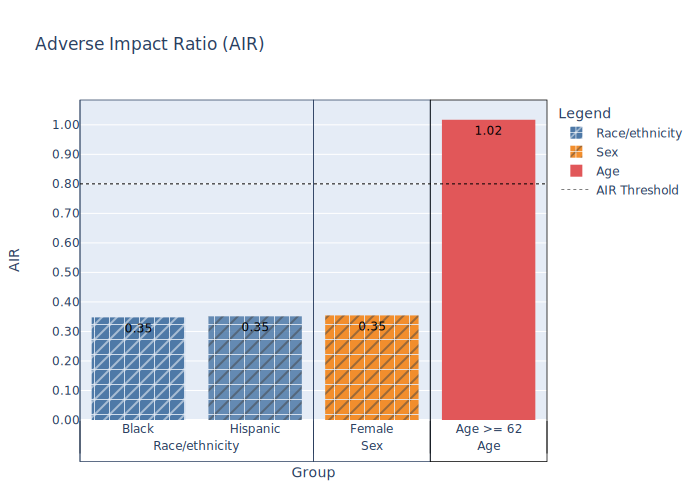

In [48]:
air = sd.adverse_impact_ratio(
    group_data=train,
    protected_groups=protected_groups,
    reference_groups=reference_groups,
    group_categories=group_categories,
    outcome=train['Offer'],
    air_threshold=0.80,
    percent_difference_threshold=0,
)
air

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

## Disparity Calculation: SMD

┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Protected Groups                      │ Black, Hispanic, Female, Age >= 62                                      │
│ Reference Groups                      │ White, White, Male, Age < 62                                            │
│ Group Categories                      │ Race/Ethnicity, Race/Ethnicity, Sex, Age                                │
│ SMD Threshold                         │ 20.0                                                                    │
│ Affected Groups                       │ Black, Hispanic, Female                                                 │
│ Affected Reference                    │ White, White, Male                                                      │
│ Affected Categories                   │ Race/Ethnicity, Race/Ethnicity, Sex                                     │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

\* Percent Missing: Age: 4.96%, Race/ethnicity: 9.97%, Sex: 0.00%

## SMD Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Average Outcome,Standard Deviation of Outcomes,SMD,P-Values,Practically Significant
Race/Ethnicity,Black,White,"63,020",9.97%,"13,082.2",0.54,0.21,37.312,0.000,Yes
Race/Ethnicity,Hispanic,White,"63,020",9.97%,"9,650.9",0.54,0.21,37.005,0.000,Yes
Race/Ethnicity,White,,"63,020",9.97%,"40,286.9",0.46,0.21,,,
Sex,Female,Male,"70,000",0.00%,"35,035.0",0.52,0.21,32.977,0.000,Yes
Sex,Male,,"70,000",0.00%,"34,965.0",0.46,0.21,,,
Age,Age >= 62,Age < 62,"66,525",4.96%,"33,273.0",0.49,0.21,-0.207,0.789,No
Age,Age < 62,,"66,525",4.96%,"33,252.0",0.49,0.21,,,


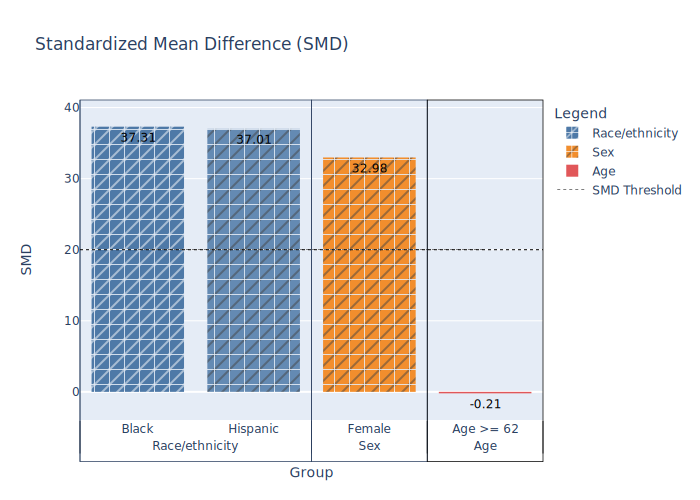

In [33]:
smd = sd.standardized_mean_difference(
    group_data=train,
    protected_groups=protected_groups,
    reference_groups=reference_groups,
    group_categories=group_categories,
    outcome=train['Model Probability'],
    lower_score_favorable=True,
    smd_threshold=20,
)
smd

### Additional Metrics in SolasAI

The SolasAI package also containes more specialized metrics that are occassionally used in highly regulated spaces. Here, we demonstrate the Adverse Impact Ratio by Quantile. This is used to test a model with an unknown use case. It tests the model predictions using the adverse impact ratio at multiple quantiles to test the level of disparity at each of these quantiles.

In [34]:
train[['Model Probability','Offer']].head()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

,Model Probability,Offer
10000,0.323092,1
10001,0.872589,0
10002,0.551457,0
10003,0.660505,0
10004,0.663962,0


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

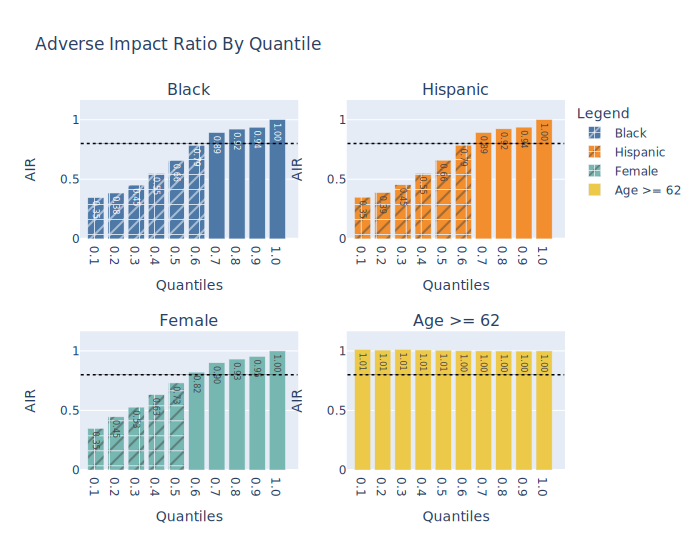

In [35]:
quantile_air = sd.adverse_impact_ratio_by_quantile(
    group_data=train,
    protected_groups=protected_groups,
    reference_groups=reference_groups,
    group_categories=group_categories,
    outcome=train['Model Probability'],
    air_threshold=0.80,
    quantiles=[x / 10 for x in range(1, 11)],
    percent_difference_threshold=0,
)
quantile_air.plot()